In [20]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [21]:
df = pd.read_csv('bananas ds/label.csv')
# print(df.head())

In [22]:
# templates_path = ['60', '61', '80', '410', '646', '897']

In [23]:
templates_path = range(100, 400, 5)
templates_path = [str(x) for x in templates_path]

In [24]:
templates = []

for filename in templates_path:

    img = cv.imread('bananas ds/images/' + filename + '.png', cv.IMREAD_GRAYSCALE)

    filename = int(filename)


    xmin = df['xmin'][filename]
    xmax = df['xmax'][filename]
    ymin = df['ymin'][filename]
    ymax = df['ymax'][filename]

    delta = 25

    if xmin>delta and ymin>delta:
        img = img[ymin-delta:ymax+delta, xmin-delta:xmax+delta]

        for _ in range(4):
            img = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
            templates.append(img)

print(len(templates))

172


In [25]:
images = []

for i in range(26):
    
    img = cv.imread('bananas ds/images/' + str(i) + '.png')

    images.append(img)

In [26]:
orb = cv.ORB.create(nfeatures=5000, nlevels=4, WTA_K=2)
segorb = cv.ORB.create(nfeatures=500, nlevels=1)

In [27]:
comparisons = []

# i = 0

fd_list = [[], [], []]  #[img[], kp[], dm[]]

for im in images:

    fd_list[0].append(im)

    im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

    img_kp, img_des = orb.detectAndCompute(im, None)

    # print("processing img - ", i)

    fd_list[1].append(img_kp)

    dm = []

    # s = 0

    matches_dist = []

    for seg in templates:

        # print("processing seg - ", s)

        # s += 1

        comp = 0

        seg_kp, seg_des = segorb.detectAndCompute(seg, None)

        matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        matches = matcher.match(img_des,seg_des)

        


        matches = sorted(matches, key = lambda x:x.distance)


        comp = cv.drawMatches(im, img_kp, seg, seg_kp, matches[0:50], None)   

        for dmatch in matches:
            if dmatch.distance < 80:
                matches_dist.append(dmatch)

        dm.append(matches_dist)

        # print(len(dm))


        comparisons.append(comp)

    fd_list[2].append(dm)

4472


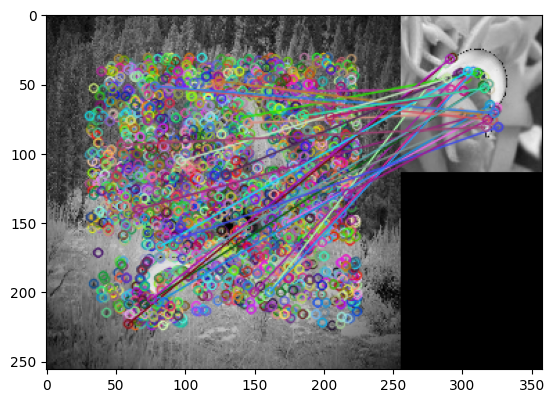

In [28]:
im = comparisons[300]

print(len(comparisons))

plt.imshow(im)

In [29]:
def get_aboxes_median(fd_list):
    """returns dataframe with predicted boxes (xyxy)

    Args:
        df_ban (list): 
            list that consists of [images[], KeyPoint_objects[], Datamatch_objects[]]

        
    """
    
    dist_list = []

    abox = 0

    dx, dy = (30, 30)

    ab_corners = [] # [filename, Axmin, Aymin, Axmax, Aymax]

    for i in range(len(fd_list[0])):

        im = fd_list[0][i]
        kp_list = fd_list[1][i]
        dm_list = fd_list[2][i]

        x_list = []
        y_list = []

        

        for dmatch_im in dm_list:
            for dmatch in dmatch_im:

                dist = dmatch.distance

                # if dist < 70:

                kp_id = dmatch.queryIdx

                # print(kp_id)

                x, y = kp_list[kp_id].pt

                
                x_list.append(x)
                y_list.append(y)

                dist_list.append(dist)

        try:
            x_mean = round(np.mean(x_list))
            y_mean = round(np.mean(y_list))
        except ValueError:
            x_mean = 0
            y_mean = 0

        # square bbox ccords (xyxy) from centr

        xmin = x_mean - dx
        ymin = y_mean - dy
        
        xmax = x_mean + dx
        ymax = y_mean + dy

        abox = cv.rectangle(im, (ymin, xmin), (ymax, xmax), (0, 0, 255), 2)

        # bbox = cv.circle(im, (y_mean, x_mean), 50, (0, 0, 255), 3)
        filename = 'bananas ds/circles/' + str(i) + '.png'

        # 1 line of DF
        
        abox_obj = (
            filename,
            xmin,
            ymin,
            xmax,
            ymax
        )

        ab_corners.append(abox_obj)

        cv.imwrite(filename, abox)

    df = pd.DataFrame(ab_corners, columns=["filename", "Axmin", "Aymin", "Axmax", "Aymax"])

    df.to_csv('bananas ds/abox.csv')
    
    print(np.mean(dist_list))

    return dist_list, df
    

In [30]:
def get_aboxes_non_min_sup(fd_list):

    dx, dy = (30, 30)

    ab_corners = [] # [filename, Axmin, Aymin, Axmax, Aymax]

    
    for i in range(len(fd_list[0])):

        im      =   fd_list[0][i]
        kp_list =   fd_list[1][i]
        dm_list =   fd_list[2][i]

        dist_list = {} # {id : dist}

        for dmatch_obj in dm_list:
            for dmatch in dmatch_obj:
                dist_list[dmatch.queryIdx] = dmatch.distance
            
        id_kp = min(dist_list.keys(), key=dist_list.get)

        x, y = kp_list[id_kp].pt

        x = round(x)
        y = round(y)

        xmin = x - dx
        xmax = x + dx
        
        ymin = y - dy
        ymax = y + dy
            
        abox = cv.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

        filename = 'bananas ds/non_min/' + str(i) + '.png'

        # 1 line of DF
        
        abox_obj = (
            filename,
            xmin,
            ymin,
            xmax,
            ymax
        )

        ab_corners.append(abox_obj)

        cv.imwrite(filename, abox)


    df = pd.DataFrame(ab_corners, columns=["filename", "Axmin", "Aymin", "Axmax", "Aymax"])

    df.to_csv('bananas ds/abox.csv')
    
    # print(np.mean(dist_list))
    
    return dist_list, df
        

In [31]:
def dispersion_calc(x_list):

    dsum = 0

    x_mean = np.mean(x_list)

    for x in x_list:
        u = (x - x_mean)**2
        dsum += u

    d = dsum/len(x_list)

    delta = math.sqrt(d)

    return delta, x_mean
    

In [32]:
def get_aboxes_dispersion(fd_list):
    """returns dataframe with predicted boxes (xyxy)

    Args:
        df_ban (list): 
            list that consists of [images[], KeyPoint_objects[], Datamatch_objects[]]

        
    """
    
    abox = 0

    ab_corners = [] # [filename, Axmin, Aymin, Axmax, Aymax]

    for i in range(len(fd_list[0])):

        im = fd_list[0][i]
        kp_list = fd_list[1][i]
        dm_list = fd_list[2][i]

        x_list = []
        y_list = []

        for dmatch_im in dm_list:
            for dmatch in dmatch_im:

                kp_id = dmatch.queryIdx
                x, y = kp_list[kp_id].pt
                
                x_list.append(x)
                y_list.append(y)


        # Dispersion calc D = (sum(x_list[i] - x_mean)^2)/len(x_list)
        
        dx, x_mean = (np.round(dispersion_calc(x_list))).astype('int')
        dy, y_mean = (np.round(dispersion_calc(y_list))).astype('int')
        
        # square bbox ccords (xyxy) from centr

        xmin = x_mean - dx
        ymin = y_mean - dy
        
        xmax = x_mean + dx
        ymax = y_mean + dy

        abox = cv.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

        # bbox = cv.circle(im, (y_mean, x_mean), 50, (0, 0, 255), 3)
        filename = 'bananas ds/dispersion/' + str(i) + '.png'

        # 1 line of DF
        
        abox_obj = (
            filename,
            xmin,
            ymin,
            xmax,
            ymax
        )

        ab_corners.append(abox_obj)

        cv.imwrite(filename, abox)

    df = pd.DataFrame(ab_corners, columns=["filename", "Axmin", "Aymin", "Axmax", "Aymax"])

    df.to_csv('bananas ds/abox.csv')
    
    return df

In [33]:
# dist_list, df = get_aboxes_median(fd_list)

In [38]:
dist_list, df = get_aboxes_non_min_sup(fd_list)


In [35]:
# df = get_aboxes_dispersion(fd_list)

In [39]:
def IOU(an_rel: np.ndarray, bbox_rel: np.ndarray) -> float:
    """Calculates and returns IoU"""

    assert an_rel.shape[-1] == 4 and bbox_rel.shape[-1] == 4, "Wrong rect size"
    ab = np.stack([an_rel, bbox_rel]).astype('float32')

    # print(ab)

    intersect_area = np.maximum(ab[..., 2:].min(axis=0) - ab[..., :2].max(axis=0), 0).prod(axis=-1)
    union_area = ((ab[..., 2] - ab[..., 0]) * (ab[..., 3] - ab[..., 1])).sum(axis=0) - intersect_area

    return intersect_area / union_area


In [40]:
old_df = pd.read_csv('bananas ds/label.csv')

pred = np.empty((len(df['filename']), 4))
real = np.empty((len(df['filename']), 4))

for i in range(len(df['filename'])):
    pred[i][0] = df['Axmin'][i]
    pred[i][1] = df['Aymin'][i]
    pred[i][2] = df['Axmax'][i]
    pred[i][3] = df['Aymax'][i]

    real[i][0] = old_df['xmin'][i]    
    real[i][1] = old_df['ymin'][i]
    real[i][2] = old_df['xmax'][i]
    real[i][3] = old_df['ymax'][i]

In [41]:
iou = IOU(pred, real)

print(np.mean(iou))



0.19289222
